<a href="https://colab.research.google.com/github/ManvithaGanne/mental-health-pediction/blob/main/Mental_Health_crisis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Mental Health Severity Classification - Complete ML Pipeline
# Predicting severity levels for Stress, Anxiety, and Depression

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder, RobustScaler
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import (classification_report, confusion_matrix, accuracy_score,
                           precision_score, recall_score, f1_score, roc_auc_score,
                           roc_curve, precision_recall_curve, auc)
from sklearn.feature_selection import SelectKBest, f_classif, RFE
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.combine import SMOTEENN
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import joblib

# Set style and suppress warnings
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")
warnings.filterwarnings('ignore')

In [2]:
# =============================================================================
# SECTION 1: DATA LOADING AND INITIAL EXPLORATION
# =============================================================================

print("=" * 80)
print("MENTAL HEALTH SEVERITY CLASSIFICATION - COMPLETE ML PIPELINE")
print("=" * 80)

# Load the dataset
df = pd.read_csv('/content/Processed.csv')  # Replace with your file path

print(f"\nDataset Overview:")
print(f"Shape: {df.shape}")
print(f"Features: {df.shape[1]}")
print(f"Samples: {df.shape[0]}")

# Display target variable distributions
print(f"\nTarget Variable Distributions:")
target_cols = ['Stress Label', 'Anxiety Label', 'Depression Label']
for col in target_cols:
    print(f"\n{col}:")
    print(df[col].value_counts())
    print(f"Percentage distribution:")
    print((df[col].value_counts() / len(df) * 100).round(2))


MENTAL HEALTH SEVERITY CLASSIFICATION - COMPLETE ML PIPELINE

Dataset Overview:
Shape: (2028, 39)
Features: 39
Samples: 2028

Target Variable Distributions:

Stress Label:
Stress Label
Moderate Stress          1348
High Perceived Stress     565
Low Stress                115
Name: count, dtype: int64
Percentage distribution:
Stress Label
Moderate Stress          66.47
High Perceived Stress    27.86
Low Stress                5.67
Name: count, dtype: float64

Anxiety Label:
Anxiety Label
Severe Anxiety      744
Moderate Anxiety    620
Mild Anxiety        505
Minimal Anxiety     159
Name: count, dtype: int64
Percentage distribution:
Anxiety Label
Severe Anxiety      36.69
Moderate Anxiety    30.57
Mild Anxiety        24.90
Minimal Anxiety      7.84
Name: count, dtype: float64

Depression Label:
Depression Label
Moderately Severe Depression    511
Severe Depression               505
Moderate Depression             457
Mild Depression                 414
Minimal Depression               97
N

In [3]:
# =============================================================================
# SECTION 2: DATA PREPROCESSING
# =============================================================================

print("\n" + "=" * 60)
print("DATA PREPROCESSING")
print("=" * 60)

# Create a copy for preprocessing
df_processed = df.copy()

# Handle missing values (if any)
print(f"Missing values before preprocessing:")
print(df_processed.isnull().sum().sum())

# Fill any missing values
if df_processed.isnull().sum().sum() > 0:
    # Fill numerical columns with median
    numerical_cols = df_processed.select_dtypes(include=[np.number]).columns
    df_processed[numerical_cols] = df_processed[numerical_cols].fillna(df_processed[numerical_cols].median())

    # Fill categorical columns with mode
    categorical_cols = df_processed.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        df_processed[col] = df_processed[col].fillna(df_processed[col].mode()[0])

print(f"Missing values after preprocessing: {df_processed.isnull().sum().sum()}")



DATA PREPROCESSING
Missing values before preprocessing:
0
Missing values after preprocessing: 0


In [4]:
# =============================================================================
# SECTION 3: FEATURE ENGINEERING
# =============================================================================

print("\n" + "=" * 60)
print("FEATURE ENGINEERING")
print("=" * 60)

# Define feature groups
demographic_features = ['Age', 'Gender', 'University', 'Department', 'Academic_Year', 'Current_CGPA', 'waiver_or_scholarship']
stress_items = [f'PSS{i}' for i in range(1, 11)]
anxiety_items = [f'GAD{i}' for i in range(1, 8)]
depression_items = [f'PHQ{i}' for i in range(1, 10)]
all_items = stress_items + anxiety_items + depression_items

# 1. Create categorical mappings
print("Creating categorical mappings...")

# Age group mapping
age_mapping = {'18-22': 0, '23-26': 1, '27-30': 2}
df_processed['Age_Numeric'] = df_processed['Age'].map(age_mapping)

# Gender encoding
gender_mapping = {'Male': 0, 'Female': 1}
df_processed['Gender_Numeric'] = df_processed['Gender'].map(gender_mapping)

# CGPA mapping
cgpa_mapping = {
    'Below 2.00': 0,
    '2.00 - 2.49': 1,
    '2.50 - 2.99': 2,
    '3.00 - 3.49': 3,
    '3.50 - 4.00': 4
}
df_processed['CGPA_Numeric'] = df_processed['Current_CGPA'].map(cgpa_mapping)

# Academic year mapping
year_mapping = {
    'First Year or Equivalent': 1,
    'Second Year or Equivalent': 2,
    'Third Year or Equivalent': 3,
    'Fourth Year or Equivalent': 4
}
df_processed['Academic_Year_Numeric'] = df_processed['Academic_Year'].map(year_mapping)

# Scholarship mapping
scholarship_mapping = {'Yes': 1, 'No': 0}
df_processed['Scholarship_Numeric'] = df_processed['waiver_or_scholarship'].map(scholarship_mapping)

# 2. Create engineered features
print("Creating engineered features...")

# Sum scores for each scale
df_processed['PSS_Sum'] = df_processed[stress_items].sum(axis=1)
df_processed['GAD_Sum'] = df_processed[anxiety_items].sum(axis=1)
df_processed['PHQ_Sum'] = df_processed[depression_items].sum(axis=1)

# Average scores
df_processed['PSS_Mean'] = df_processed[stress_items].mean(axis=1)
df_processed['GAD_Mean'] = df_processed[anxiety_items].mean(axis=1)
df_processed['PHQ_Mean'] = df_processed[depression_items].mean(axis=1)

# Standard deviation (variability in responses)
df_processed['PSS_Std'] = df_processed[stress_items].std(axis=1)
df_processed['GAD_Std'] = df_processed[anxiety_items].std(axis=1)
df_processed['PHQ_Std'] = df_processed[depression_items].std(axis=1)

# Range (max - min)
df_processed['PSS_Range'] = df_processed[stress_items].max(axis=1) - df_processed[stress_items].min(axis=1)
df_processed['GAD_Range'] = df_processed[anxiety_items].max(axis=1) - df_processed[anxiety_items].min(axis=1)
df_processed['PHQ_Range'] = df_processed[depression_items].max(axis=1) - df_processed[depression_items].min(axis=1)

# Cross-scale features
df_processed['Total_Mental_Health_Score'] = df_processed['PSS_Sum'] + df_processed['GAD_Sum'] + df_processed['PHQ_Sum']
df_processed['Stress_Anxiety_Ratio'] = df_processed['PSS_Sum'] / (df_processed['GAD_Sum'] + 1)  # +1 to avoid division by zero
df_processed['Depression_Anxiety_Ratio'] = df_processed['PHQ_Sum'] / (df_processed['GAD_Sum'] + 1)

# High response indicators (count of high scores - 3 or 4)
df_processed['PSS_High_Count'] = (df_processed[stress_items] >= 3).sum(axis=1)
df_processed['GAD_High_Count'] = (df_processed[anxiety_items] >= 3).sum(axis=1)
df_processed['PHQ_High_Count'] = (df_processed[depression_items] >= 3).sum(axis=1)

# University and Department encoding (using frequency encoding to handle high cardinality)
university_freq = df_processed['University'].value_counts().to_dict()
department_freq = df_processed['Department'].value_counts().to_dict()

df_processed['University_Freq'] = df_processed['University'].map(university_freq)
df_processed['Department_Freq'] = df_processed['Department'].map(department_freq)

print(f"Total features after engineering: {df_processed.shape[1]}")



FEATURE ENGINEERING
Creating categorical mappings...
Creating engineered features...
Total features after engineering: 64


In [5]:
# =============================================================================
# SECTION 4: PREPARE DATASETS FOR EACH TARGET
# =============================================================================

print("\n" + "=" * 60)
print("PREPARING DATASETS FOR CLASSIFICATION")
print("=" * 60)

# Define feature columns (excluding target variables and original categorical columns)
feature_columns = (
    ['Age_Numeric', 'Gender_Numeric', 'CGPA_Numeric', 'Academic_Year_Numeric', 'Scholarship_Numeric',
     'University_Freq', 'Department_Freq'] +
    all_items +
    ['PSS_Sum', 'GAD_Sum', 'PHQ_Sum', 'PSS_Mean', 'GAD_Mean', 'PHQ_Mean',
     'PSS_Std', 'GAD_Std', 'PHQ_Std', 'PSS_Range', 'GAD_Range', 'PHQ_Range',
     'Total_Mental_Health_Score', 'Stress_Anxiety_Ratio', 'Depression_Anxiety_Ratio',
     'PSS_High_Count', 'GAD_High_Count', 'PHQ_High_Count']
)

# Remove any columns that might have NaN after feature engineering
feature_columns = [col for col in feature_columns if col in df_processed.columns and df_processed[col].isnull().sum() == 0]

X = df_processed[feature_columns].copy()

# Handle any remaining NaN values in features
X = X.fillna(X.median())

print(f"Final feature set shape: {X.shape}")
print(f"Features used: {len(feature_columns)}")

# Prepare targets
targets = {
    'Stress': 'Stress Label',
    'Anxiety': 'Anxiety Label',
    'Depression': 'Depression Label'
}

# Create label encoders for each target
label_encoders = {}
y_encoded = {}

for condition, target_col in targets.items():
    le = LabelEncoder()
    y_encoded[condition] = le.fit_transform(df_processed[target_col])
    label_encoders[condition] = le

    print(f"\n{condition} classes:")
    for i, class_name in enumerate(le.classes_):
        print(f"  {i}: {class_name} ({(y_encoded[condition] == i).sum()} samples)")



PREPARING DATASETS FOR CLASSIFICATION
Final feature set shape: (2028, 47)
Features used: 47

Stress classes:
  0: High Perceived Stress (565 samples)
  1: Low Stress (115 samples)
  2: Moderate Stress (1348 samples)

Anxiety classes:
  0: Mild Anxiety (505 samples)
  1: Minimal Anxiety (159 samples)
  2: Moderate Anxiety (620 samples)
  3: Severe Anxiety (744 samples)

Depression classes:
  0: Mild Depression (414 samples)
  1: Minimal Depression (97 samples)
  2: Moderate Depression (457 samples)
  3: Moderately Severe Depression (511 samples)
  4: No Depression (44 samples)
  5: Severe Depression (505 samples)


In [6]:
# =============================================================================
# SECTION 5: MODEL BUILDING AND TRAINING
# =============================================================================

print("\n" + "=" * 60)
print("MODEL BUILDING AND TRAINING")
print("=" * 60)

# Define models to test
models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='mlogloss'),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Naive Bayes': GaussianNB(),
    'Decision Tree': DecisionTreeClassifier(random_state=42)
}

# Storage for results
results = {}
trained_models = {}
scalers = {}

# Train models for each condition
for condition in targets.keys():
    print(f"\n{'='*40}")
    print(f"TRAINING MODELS FOR {condition.upper()}")
    print(f"{'='*40}")

    y = y_encoded[condition]

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    scalers[condition] = scaler

    # Handle class imbalance with SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    print(f"Original training set shape: {X_train_scaled.shape}")
    print(f"Resampled training set shape: {X_train_balanced.shape}")
    print(f"Class distribution after SMOTE: {np.bincount(y_train_balanced)}")

    # Train and evaluate models
    condition_results = {}
    condition_models = {}

    for name, model in models.items():
        print(f"\nTraining {name}...")

        # Train model
        model.fit(X_train_balanced, y_train_balanced)

        # Predictions
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled) if hasattr(model, 'predict_proba') else None

        # Evaluate
        accuracy = accuracy_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred, average='weighted')
        recall = recall_score(y_test, y_pred, average='weighted')
        f1 = f1_score(y_test, y_pred, average='weighted')

        # Store results
        condition_results[name] = {
            'accuracy': accuracy,
            'precision': precision,
            'recall': recall,
            'f1_score': f1,
            'y_test': y_test,
            'y_pred': y_pred,
            'y_pred_proba': y_pred_proba
        }

        condition_models[name] = model

        print(f"  Accuracy: {accuracy:.4f}")
        print(f"  F1-Score: {f1:.4f}")

    results[condition] = condition_results
    trained_models[condition] = condition_models



MODEL BUILDING AND TRAINING

TRAINING MODELS FOR STRESS
Original training set shape: (1622, 47)
Resampled training set shape: (3234, 47)
Class distribution after SMOTE: [1078 1078 1078]

Training Random Forest...
  Accuracy: 0.9310
  F1-Score: 0.9301

Training XGBoost...
  Accuracy: 0.9606
  F1-Score: 0.9604

Training Logistic Regression...
  Accuracy: 0.9803
  F1-Score: 0.9806

Training SVM...
  Accuracy: 0.9655
  F1-Score: 0.9667

Training Gradient Boosting...
  Accuracy: 0.9606
  F1-Score: 0.9606

Training K-Nearest Neighbors...
  Accuracy: 0.8498
  F1-Score: 0.8618

Training Naive Bayes...
  Accuracy: 0.8005
  F1-Score: 0.8183

Training Decision Tree...
  Accuracy: 0.8990
  F1-Score: 0.8994

TRAINING MODELS FOR ANXIETY
Original training set shape: (1622, 47)
Resampled training set shape: (2380, 47)
Class distribution after SMOTE: [595 595 595 595]

Training Random Forest...
  Accuracy: 1.0000
  F1-Score: 1.0000

Training XGBoost...
  Accuracy: 1.0000
  F1-Score: 1.0000

Training L

In [7]:
# =============================================================================
# SECTION 6: MODEL EVALUATION AND COMPARISON
# =============================================================================

print("\n" + "=" * 60)
print("MODEL EVALUATION AND COMPARISON")
print("=" * 60)

# Create comparison dataframes
comparison_data = []

for condition, condition_results in results.items():
    for model_name, metrics in condition_results.items():
        comparison_data.append({
            'Condition': condition,
            'Model': model_name,
            'Accuracy': metrics['accuracy'],
            'Precision': metrics['precision'],
            'Recall': metrics['recall'],
            'F1_Score': metrics['f1_score']
        })

comparison_df = pd.DataFrame(comparison_data)

# Display best models for each condition
print("\nBest Models by F1-Score:")
for condition in targets.keys():
    condition_data = comparison_df[comparison_df['Condition'] == condition]
    best_model = condition_data.loc[condition_data['F1_Score'].idxmax()]
    print(f"\n{condition}:")
    print(f"  Best Model: {best_model['Model']}")
    print(f"  F1-Score: {best_model['F1_Score']:.4f}")
    print(f"  Accuracy: {best_model['Accuracy']:.4f}")
    print(f"  Precision: {best_model['Precision']:.4f}")
    print(f"  Recall: {best_model['Recall']:.4f}")



MODEL EVALUATION AND COMPARISON

Best Models by F1-Score:

Stress:
  Best Model: Logistic Regression
  F1-Score: 0.9806
  Accuracy: 0.9803
  Precision: 0.9810
  Recall: 0.9803

Anxiety:
  Best Model: Random Forest
  F1-Score: 1.0000
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000

Depression:
  Best Model: Random Forest
  F1-Score: 1.0000
  Accuracy: 1.0000
  Precision: 1.0000
  Recall: 1.0000


In [8]:
# =============================================================================
# SECTION 7: DETAILED EVALUATION FOR BEST MODELS
# =============================================================================

print("\n" + "=" * 60)
print("DETAILED EVALUATION FOR BEST MODELS")
print("=" * 60)

best_models = {}

for condition in targets.keys():
    condition_data = comparison_df[comparison_df['Condition'] == condition]
    best_model_name = condition_data.loc[condition_data['F1_Score'].idxmax(), 'Model']
    best_models[condition] = best_model_name

    print(f"\n{condition.upper()} - {best_model_name}")
    print("-" * 50)

    # Get results for best model
    best_results = results[condition][best_model_name]
    y_test = best_results['y_test']
    y_pred = best_results['y_pred']

    # Classification report
    target_names = label_encoders[condition].classes_
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=target_names))

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print(f"\nConfusion Matrix:")
    print(cm)



DETAILED EVALUATION FOR BEST MODELS

STRESS - Logistic Regression
--------------------------------------------------

Classification Report:
                       precision    recall  f1-score   support

High Perceived Stress       0.99      0.99      0.99       113
           Low Stress       0.84      0.91      0.88        23
      Moderate Stress       0.99      0.98      0.99       270

             accuracy                           0.98       406
            macro avg       0.94      0.96      0.95       406
         weighted avg       0.98      0.98      0.98       406


Confusion Matrix:
[[112   0   1]
 [  0  21   2]
 [  1   4 265]]

ANXIETY - Random Forest
--------------------------------------------------

Classification Report:
                  precision    recall  f1-score   support

    Mild Anxiety       1.00      1.00      1.00       101
 Minimal Anxiety       1.00      1.00      1.00        32
Moderate Anxiety       1.00      1.00      1.00       124
  Severe Anxiety


CREATING VISUALIZATIONS


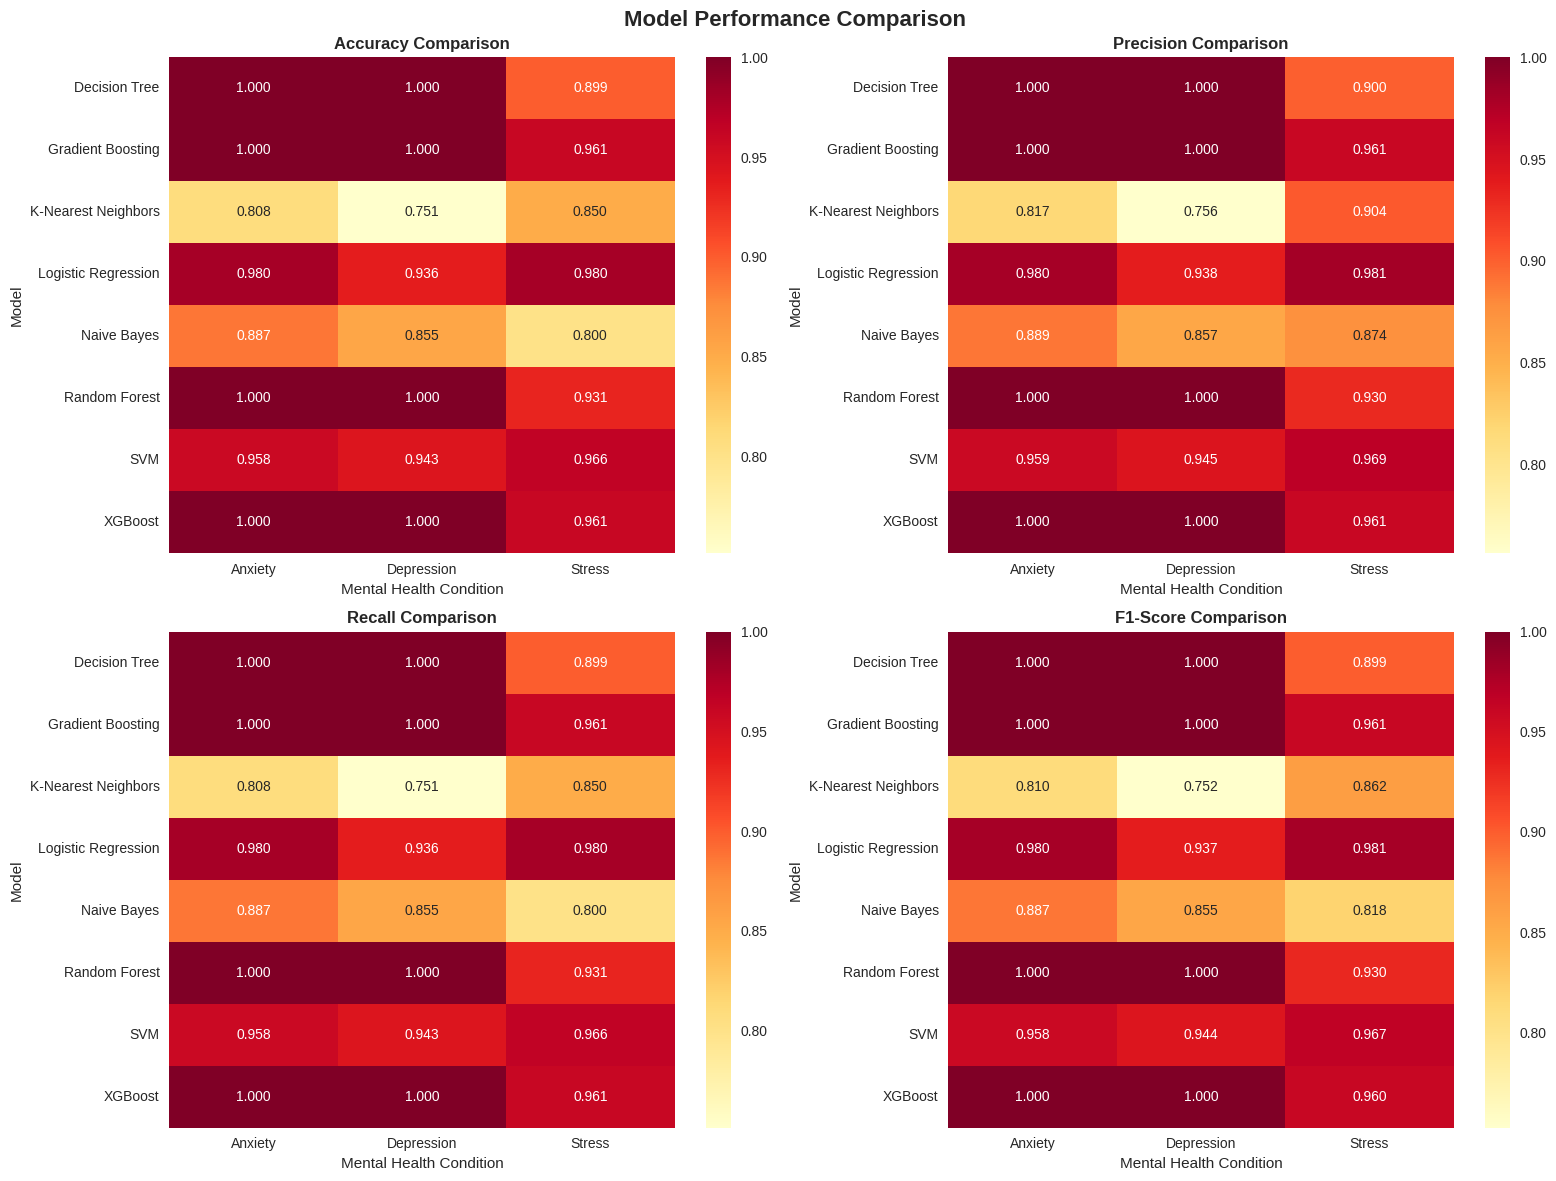

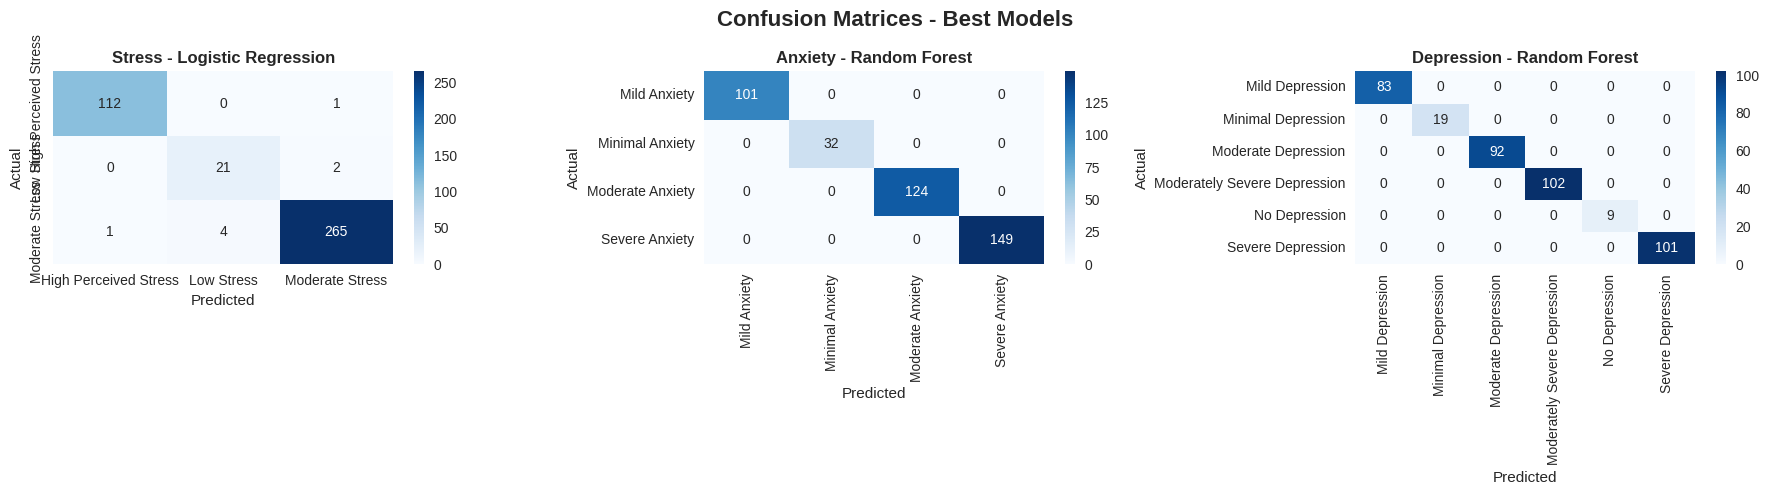


Feature Importance Analysis:


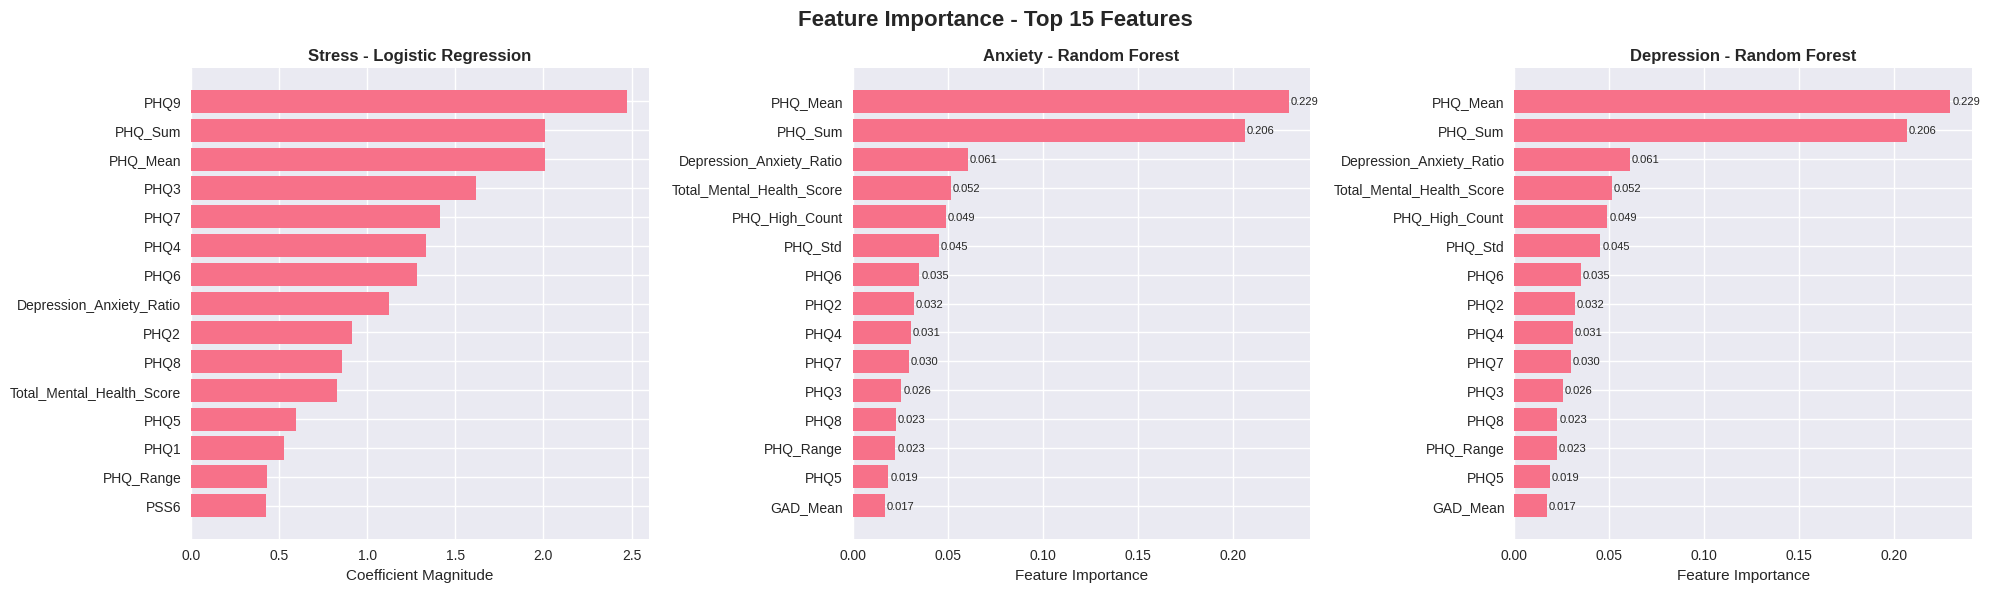

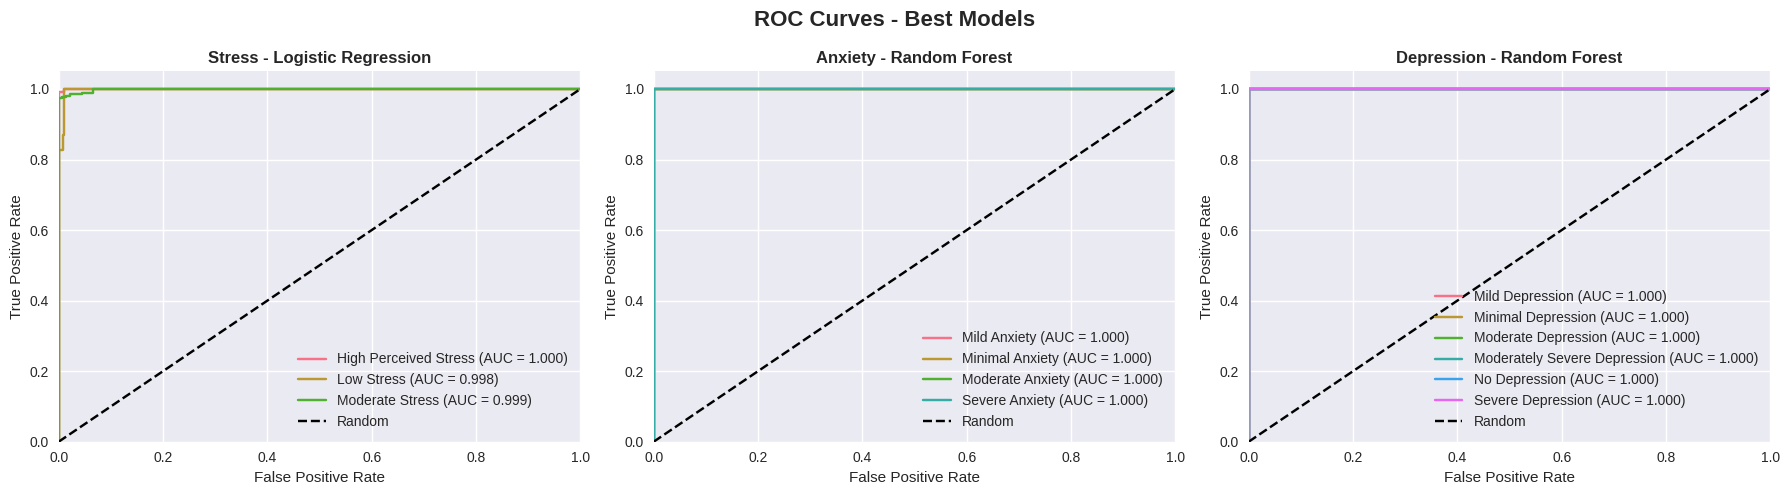

In [9]:
# =============================================================================
# SECTION 8: VISUALIZATIONS
# =============================================================================

print("\n" + "=" * 60)
print("CREATING VISUALIZATIONS")
print("=" * 60)

# 1. Model Comparison Heatmap
fig, axes = plt.subplots(2, 2, figsize=(16, 12))
fig.suptitle('Model Performance Comparison', fontsize=16, fontweight='bold')

metrics = ['Accuracy', 'Precision', 'Recall', 'F1_Score']
metric_names = ['Accuracy', 'Precision', 'Recall', 'F1-Score']

for i, (metric, metric_name) in enumerate(zip(metrics, metric_names)):
    ax = axes[i//2, i%2]

    # Create pivot table for heatmap
    pivot_data = comparison_df.pivot(index='Model', columns='Condition', values=metric)

    # Create heatmap
    sns.heatmap(pivot_data, annot=True, cmap='YlOrRd', fmt='.3f', ax=ax)
    ax.set_title(f'{metric_name} Comparison', fontweight='bold')
    ax.set_xlabel('Mental Health Condition')
    ax.set_ylabel('Model')

plt.tight_layout()
plt.show()

# 2. Confusion Matrices for Best Models
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Confusion Matrices - Best Models', fontsize=16, fontweight='bold')

for i, (condition, best_model_name) in enumerate(best_models.items()):
    ax = axes[i]

    # Get results
    best_results = results[condition][best_model_name]
    y_test = best_results['y_test']
    y_pred = best_results['y_pred']

    # Confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    target_names = label_encoders[condition].classes_

    # Plot
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=target_names, yticklabels=target_names)
    ax.set_title(f'{condition} - {best_model_name}', fontweight='bold')
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')

plt.tight_layout()
plt.show()

# 3. Feature Importance Analysis
print("\nFeature Importance Analysis:")

fig, axes = plt.subplots(1, 3, figsize=(20, 6))
fig.suptitle('Feature Importance - Top 15 Features', fontsize=16, fontweight='bold')

for i, (condition, best_model_name) in enumerate(best_models.items()):
    ax = axes[i]

    # Get the best model
    best_model = trained_models[condition][best_model_name]

    # Get feature importance (if available)
    if hasattr(best_model, 'feature_importances_'):
        importances = best_model.feature_importances_
        feature_names = feature_columns

        # Sort and get top 15
        indices = np.argsort(importances)[::-1][:15]
        top_features = [feature_names[i] for i in indices]
        top_importances = importances[indices]

        # Plot
        bars = ax.barh(range(len(top_features)), top_importances[::-1])
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features[::-1])
        ax.set_xlabel('Feature Importance')
        ax.set_title(f'{condition} - {best_model_name}', fontweight='bold')

        # Add value labels
        for j, bar in enumerate(bars):
            width = bar.get_width()
            ax.text(width + 0.001, bar.get_y() + bar.get_height()/2,
                   f'{width:.3f}', ha='left', va='center', fontsize=8)

    elif hasattr(best_model, 'coef_'):
        # For linear models, use coefficient magnitudes
        coef = np.abs(best_model.coef_[0]) if best_model.coef_.ndim > 1 else np.abs(best_model.coef_)
        feature_names = feature_columns

        # Sort and get top 15
        indices = np.argsort(coef)[::-1][:15]
        top_features = [feature_names[i] for i in indices]
        top_coef = coef[indices]

        # Plot
        bars = ax.barh(range(len(top_features)), top_coef[::-1])
        ax.set_yticks(range(len(top_features)))
        ax.set_yticklabels(top_features[::-1])
        ax.set_xlabel('Coefficient Magnitude')
        ax.set_title(f'{condition} - {best_model_name}', fontweight='bold')

plt.tight_layout()
plt.show()

# 4. ROC Curves (for binary classification or one-vs-rest for multiclass)
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('ROC Curves - Best Models', fontsize=16, fontweight='bold')

for i, (condition, best_model_name) in enumerate(best_models.items()):
    ax = axes[i]

    # Get results
    best_results = results[condition][best_model_name]
    y_test = best_results['y_test']
    y_pred_proba = best_results['y_pred_proba']

    if y_pred_proba is not None:
        # Number of classes
        n_classes = len(label_encoders[condition].classes_)

        if n_classes == 2:
            # Binary classification
            fpr, tpr, _ = roc_curve(y_test, y_pred_proba[:, 1])
            roc_auc = auc(fpr, tpr)
            ax.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
        else:
            # Multiclass - One vs Rest
            from sklearn.preprocessing import label_binarize
            from sklearn.metrics import roc_curve, auc

            # Binarize the output
            y_test_bin = label_binarize(y_test, classes=range(n_classes))

            # Compute ROC curve and ROC area for each class
            fpr = dict()
            tpr = dict()
            roc_auc = dict()

            for j in range(n_classes):
                fpr[j], tpr[j], _ = roc_curve(y_test_bin[:, j], y_pred_proba[:, j])
                roc_auc[j] = auc(fpr[j], tpr[j])
                class_name = label_encoders[condition].classes_[j]
                ax.plot(fpr[j], tpr[j],
                       label=f'{class_name} (AUC = {roc_auc[j]:.3f})')

        ax.plot([0, 1], [0, 1], 'k--', label='Random')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title(f'{condition} - {best_model_name}', fontweight='bold')
        ax.legend(loc="lower right")
    else:
        ax.text(0.5, 0.5, 'No probability predictions available',
                ha='center', va='center', transform=ax.transAxes)
        ax.set_title(f'{condition} - {best_model_name}', fontweight='bold')

plt.tight_layout()
plt.show()



CROSS-VALIDATION ANALYSIS

Cross-validation for Stress - Logistic Regression:
  CV F1-Scores: [0.98235337 0.97194944 0.96567454 0.98495866 0.99012346]
  Mean CV F1-Score: 0.9790 (+/- 0.0178)

Cross-validation for Anxiety - Random Forest:
  CV F1-Scores: [1. 1. 1. 1. 1.]
  Mean CV F1-Score: 1.0000 (+/- 0.0000)

Cross-validation for Depression - Random Forest:
  CV F1-Scores: [1.         1.         0.99751274 1.         1.        ]
  Mean CV F1-Score: 0.9995 (+/- 0.0020)


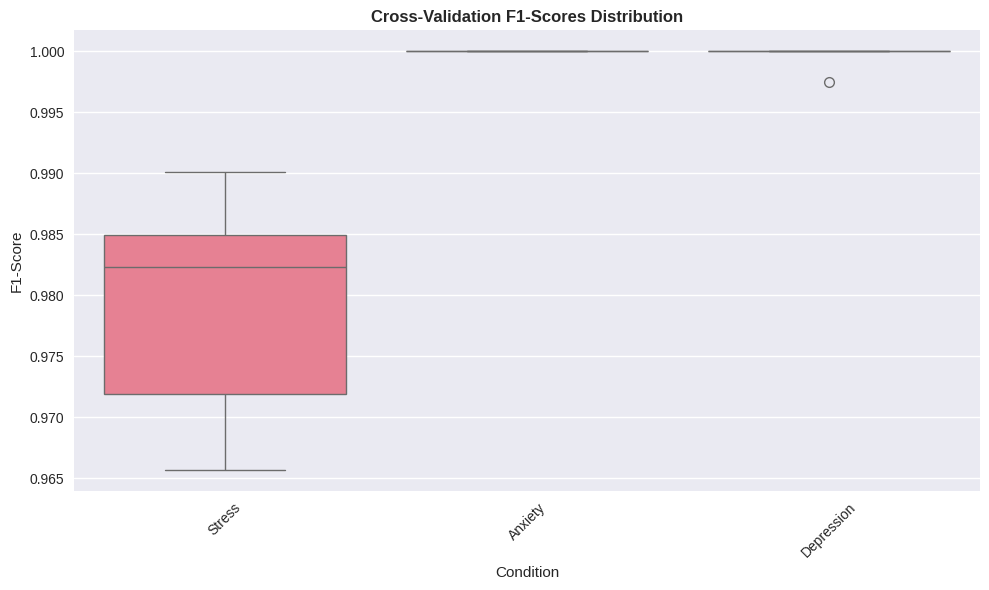

In [10]:
# =============================================================================
# SECTION 9: CROSS-VALIDATION ANALYSIS
# =============================================================================

print("\n" + "=" * 60)
print("CROSS-VALIDATION ANALYSIS")
print("=" * 60)

# Perform 5-fold cross-validation for best models
cv_results = {}

for condition, best_model_name in best_models.items():
    print(f"\nCross-validation for {condition} - {best_model_name}:")

    # Get the model
    model = trained_models[condition][best_model_name]
    y = y_encoded[condition]

    # Scale features
    scaler = scalers[condition]
    X_scaled = scaler.fit_transform(X)

    # 5-fold stratified cross-validation
    cv_scores = cross_val_score(model, X_scaled, y, cv=StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
                               scoring='f1_weighted', n_jobs=-1)

    cv_results[condition] = cv_scores

    print(f"  CV F1-Scores: {cv_scores}")
    print(f"  Mean CV F1-Score: {cv_scores.mean():.4f} (+/- {cv_scores.std() * 2:.4f})")

# Visualize cross-validation results
plt.figure(figsize=(10, 6))
cv_data = []
for condition, scores in cv_results.items():
    for score in scores:
        cv_data.append({'Condition': condition, 'F1_Score': score})

cv_df = pd.DataFrame(cv_data)
sns.boxplot(data=cv_df, x='Condition', y='F1_Score')
plt.title('Cross-Validation F1-Scores Distribution', fontweight='bold')
plt.ylabel('F1-Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [11]:
# =============================================================================
# SECTION 10: HYPERPARAMETER TUNING FOR BEST MODELS
# =============================================================================

print("\n" + "=" * 60)
print("HYPERPARAMETER TUNING FOR BEST MODELS")
print("=" * 60)

tuned_models = {}

for condition, best_model_name in best_models.items():
    print(f"\nTuning hyperparameters for {condition} - {best_model_name}...")

    y = y_encoded[condition]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = scalers[condition]
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    # Define parameter grids for different models
    param_grids = {
        'Random Forest': {
            'n_estimators': [100, 200],
            'max_depth': [10, 20, None],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        },
        'XGBoost': {
            'n_estimators': [100, 200],
            'max_depth': [3, 6, 10],
            'learning_rate': [0.01, 0.1, 0.2],
            'subsample': [0.8, 1.0]
        },
        'Logistic Regression': {
            'C': [0.1, 1.0, 10.0],
            'penalty': ['l1', 'l2'],
            'solver': ['liblinear', 'saga']
        },
        'SVM': {
            'C': [0.1, 1, 10],
            'gamma': ['scale', 'auto'],
            'kernel': ['rbf', 'linear']
        }
    }

    if best_model_name in param_grids:
        # Create a fresh model instance
        if best_model_name == 'Random Forest':
            base_model = RandomForestClassifier(random_state=42, n_jobs=-1)
        elif best_model_name == 'XGBoost':
            base_model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
        elif best_model_name == 'Logistic Regression':
            base_model = LogisticRegression(random_state=42, max_iter=1000)
        elif best_model_name == 'SVM':
            base_model = SVC(random_state=42, probability=True)

        # Grid search
        grid_search = GridSearchCV(
            base_model,
            param_grids[best_model_name],
            cv=3,  # Reduced for faster execution
            scoring='f1_weighted',
            n_jobs=-1,
            verbose=0
        )

        grid_search.fit(X_train_balanced, y_train_balanced)

        # Get best model
        best_tuned_model = grid_search.best_estimator_
        tuned_models[condition] = best_tuned_model

        # Evaluate tuned model
        y_pred_tuned = best_tuned_model.predict(X_test_scaled)
        f1_tuned = f1_score(y_test, y_pred_tuned, average='weighted')
        accuracy_tuned = accuracy_score(y_test, y_pred_tuned)

        print(f"  Best parameters: {grid_search.best_params_}")
        print(f"  Best CV F1-score: {grid_search.best_score_:.4f}")
        print(f"  Test F1-score (tuned): {f1_tuned:.4f}")
        print(f"  Test Accuracy (tuned): {accuracy_tuned:.4f}")

        # Compare with original model
        original_f1 = results[condition][best_model_name]['f1_score']
        improvement = f1_tuned - original_f1
        print(f"  Improvement: {improvement:.4f}")
    else:
        print(f"  No parameter grid defined for {best_model_name}")
        tuned_models[condition] = trained_models[condition][best_model_name]



HYPERPARAMETER TUNING FOR BEST MODELS

Tuning hyperparameters for Stress - Logistic Regression...
  Best parameters: {'C': 10.0, 'penalty': 'l1', 'solver': 'liblinear'}
  Best CV F1-score: 0.9898
  Test F1-score (tuned): 0.9927
  Test Accuracy (tuned): 0.9926
  Improvement: 0.0121

Tuning hyperparameters for Anxiety - Random Forest...
  Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Best CV F1-score: 1.0000
  Test F1-score (tuned): 1.0000
  Test Accuracy (tuned): 1.0000
  Improvement: 0.0000

Tuning hyperparameters for Depression - Random Forest...
  Best parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}
  Best CV F1-score: 1.0000
  Test F1-score (tuned): 1.0000
  Test Accuracy (tuned): 1.0000
  Improvement: 0.0000


In [12]:
# =============================================================================
# SECTION 11: ENSEMBLE MODEL CREATION
# =============================================================================

print("\n" + "=" * 60)
print("ENSEMBLE MODEL CREATION")
print("=" * 60)

ensemble_models = {}

for condition in targets.keys():
    print(f"\nCreating ensemble for {condition}...")

    y = y_encoded[condition]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = scalers[condition]
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Apply SMOTE
    smote = SMOTE(random_state=42)
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

    # Create ensemble with top 3 performing models
    condition_results_sorted = sorted(results[condition].items(),
                                    key=lambda x: x[1]['f1_score'], reverse=True)
    top_3_models = condition_results_sorted[:3]

    # Initialize fresh models for ensemble
    ensemble_estimators = []
    for model_name, _ in top_3_models:
        if model_name == 'Random Forest':
            model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
        elif model_name == 'XGBoost':
            model = xgb.XGBClassifier(random_state=42, eval_metric='mlogloss')
        elif model_name == 'Logistic Regression':
            model = LogisticRegression(random_state=42, max_iter=1000)
        elif model_name == 'SVM':
            model = SVC(random_state=42, probability=True)
        elif model_name == 'Gradient Boosting':
            model = GradientBoostingClassifier(random_state=42)
        elif model_name == 'K-Nearest Neighbors':
            model = KNeighborsClassifier()
        elif model_name == 'Naive Bayes':
            model = GaussianNB()
        elif model_name == 'Decision Tree':
            model = DecisionTreeClassifier(random_state=42)

        ensemble_estimators.append((model_name, model))

    # Create voting classifier
    ensemble = VotingClassifier(estimators=ensemble_estimators, voting='soft')
    ensemble.fit(X_train_balanced, y_train_balanced)

    # Evaluate ensemble
    y_pred_ensemble = ensemble.predict(X_test_scaled)
    f1_ensemble = f1_score(y_test, y_pred_ensemble, average='weighted')
    accuracy_ensemble = accuracy_score(y_test, y_pred_ensemble)

    ensemble_models[condition] = ensemble

    print(f"  Top 3 models: {[name for name, _ in top_3_models]}")
    print(f"  Ensemble F1-score: {f1_ensemble:.4f}")
    print(f"  Ensemble Accuracy: {accuracy_ensemble:.4f}")

    # Compare with best individual model
    best_individual_f1 = max([metrics['f1_score'] for metrics in results[condition].values()])
    improvement = f1_ensemble - best_individual_f1
    print(f"  Improvement over best individual: {improvement:.4f}")



ENSEMBLE MODEL CREATION

Creating ensemble for Stress...
  Top 3 models: ['Logistic Regression', 'SVM', 'Gradient Boosting']
  Ensemble F1-score: 0.9825
  Ensemble Accuracy: 0.9828
  Improvement over best individual: 0.0019

Creating ensemble for Anxiety...
  Top 3 models: ['Random Forest', 'XGBoost', 'Gradient Boosting']
  Ensemble F1-score: 1.0000
  Ensemble Accuracy: 1.0000
  Improvement over best individual: 0.0000

Creating ensemble for Depression...
  Top 3 models: ['Random Forest', 'XGBoost', 'Gradient Boosting']
  Ensemble F1-score: 1.0000
  Ensemble Accuracy: 1.0000
  Improvement over best individual: 0.0000


In [13]:
# =============================================================================
# SECTION 12: PREDICTION FUNCTION AND EXAMPLE USAGE
# =============================================================================

print("\n" + "=" * 60)
print("PREDICTION FUNCTION AND EXAMPLE USAGE")
print("=" * 60)

def predict_mental_health_severity(new_data, condition='all'):
    """
    Predict mental health severity for new data

    Parameters:
    new_data: pandas DataFrame with same features as training data
    condition: 'Stress', 'Anxiety', 'Depression', or 'all'

    Returns:
    Dictionary with predictions and probabilities
    """
    predictions = {}

    # Prepare features (same preprocessing as training)
    X_new = new_data[feature_columns].copy()
    X_new = X_new.fillna(X_new.median())

    conditions_to_predict = [condition] if condition != 'all' else list(targets.keys())

    for cond in conditions_to_predict:
        # Scale features
        scaler = scalers[cond]
        X_new_scaled = scaler.transform(X_new)

        # Use tuned model if available, otherwise use ensemble
        if cond in tuned_models:
            model = tuned_models[cond]
        else:
            model = ensemble_models[cond]

        # Make predictions
        pred_labels = model.predict(X_new_scaled)
        pred_proba = model.predict_proba(X_new_scaled) if hasattr(model, 'predict_proba') else None

        # Convert back to original labels
        pred_labels_original = label_encoders[cond].inverse_transform(pred_labels)

        predictions[cond] = {
            'predicted_labels': pred_labels_original,
            'predicted_probabilities': pred_proba,
            'class_names': label_encoders[cond].classes_
        }

    return predictions

# Example usage with a sample from the dataset
print("\nExample Prediction:")
sample_data = df_processed.iloc[[0]].copy()  # Take first row as example

# Make prediction
example_predictions = predict_mental_health_severity(sample_data, condition='all')

print(f"\nSample data (first row):")
print(f"Age: {sample_data['Age'].values[0]}")
print(f"Gender: {sample_data['Gender'].values[0]}")
print(f"Academic Year: {sample_data['Academic_Year'].values[0]}")
print(f"CGPA: {sample_data['Current_CGPA'].values[0]}")

print(f"\nPredictions:")
for condition, pred_data in example_predictions.items():
    predicted_label = pred_data['predicted_labels'][0]
    if pred_data['predicted_probabilities'] is not None:
        proba = pred_data['predicted_probabilities'][0]
        max_proba = np.max(proba)
        print(f"{condition}: {predicted_label} (confidence: {max_proba:.3f})")
    else:
        print(f"{condition}: {predicted_label}")


PREDICTION FUNCTION AND EXAMPLE USAGE

Example Prediction:

Sample data (first row):
Age: 18-22
Gender: Female
Academic Year: Second Year or Equivalent
CGPA: 2.50 - 2.99

Predictions:
Stress: High Perceived Stress (confidence: 0.745)
Anxiety: Severe Anxiety (confidence: 0.949)
Depression: Severe Depression (confidence: 0.902)


In [14]:
# =============================================================================
# SECTION 13: MODEL INTERPRETATION AND INSIGHTS
# =============================================================================

print("\n" + "=" * 60)
print("MODEL INTERPRETATION AND INSIGHTS")
print("=" * 60)

# Feature importance analysis across conditions
print("\nTop 10 Most Important Features Across All Conditions:")
print("-" * 55)

all_feature_importance = {}

for condition, best_model_name in best_models.items():
    model = trained_models[condition][best_model_name]

    if hasattr(model, 'feature_importances_'):
        importances = model.feature_importances_
        for i, feature in enumerate(feature_columns):
            if feature not in all_feature_importance:
                all_feature_importance[feature] = []
            all_feature_importance[feature].append(importances[i])

# Average importance across conditions
avg_importance = {feature: np.mean(scores) for feature, scores in all_feature_importance.items()}
sorted_features = sorted(avg_importance.items(), key=lambda x: x[1], reverse=True)

print("\nAverage Feature Importance Ranking:")
for i, (feature, importance) in enumerate(sorted_features[:15], 1):
    print(f"{i:2d}. {feature:<25} {importance:.4f}")



MODEL INTERPRETATION AND INSIGHTS

Top 10 Most Important Features Across All Conditions:
-------------------------------------------------------

Average Feature Importance Ranking:
 1. PHQ_Mean                  0.2295
 2. PHQ_Sum                   0.2064
 3. Depression_Anxiety_Ratio  0.0608
 4. Total_Mental_Health_Score 0.0515
 5. PHQ_High_Count            0.0490
 6. PHQ_Std                   0.0454
 7. PHQ6                      0.0352
 8. PHQ2                      0.0320
 9. PHQ4                      0.0307
10. PHQ7                      0.0297
11. PHQ3                      0.0257
12. PHQ8                      0.0227
13. PHQ_Range                 0.0225
14. PHQ5                      0.0188
15. GAD_Mean                  0.0170


In [15]:
# =============================================================================
# SECTION 14: MODEL PERFORMANCE SUMMARY
# =============================================================================

print("\n" + "=" * 60)
print("FINAL MODEL PERFORMANCE SUMMARY")
print("=" * 60)

summary_data = []

for condition in targets.keys():
    # Original best model performance
    best_model_name = best_models[condition]
    original_performance = results[condition][best_model_name]

    # Tuned model performance (if available)
    if condition in tuned_models:
        # Re-evaluate tuned model for consistent comparison
        y = y_encoded[condition]
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        scaler = scalers[condition]
        X_test_scaled = scaler.transform(X_test)

        tuned_pred = tuned_models[condition].predict(X_test_scaled)
        tuned_f1 = f1_score(y_test, tuned_pred, average='weighted')
        tuned_accuracy = accuracy_score(y_test, tuned_pred)
    else:
        tuned_f1 = original_performance['f1_score']
        tuned_accuracy = original_performance['accuracy']

    # Ensemble performance
    y = y_encoded[condition]
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )
    scaler = scalers[condition]
    X_test_scaled = scaler.transform(X_test)

    ensemble_pred = ensemble_models[condition].predict(X_test_scaled)
    ensemble_f1 = f1_score(y_test, ensemble_pred, average='weighted')
    ensemble_accuracy = accuracy_score(y_test, ensemble_pred)

    summary_data.append({
        'Condition': condition,
        'Best_Model': best_model_name,
        'Original_F1': original_performance['f1_score'],
        'Original_Accuracy': original_performance['accuracy'],
        'Tuned_F1': tuned_f1,
        'Tuned_Accuracy': tuned_accuracy,
        'Ensemble_F1': ensemble_f1,
        'Ensemble_Accuracy': ensemble_accuracy
    })

summary_df = pd.DataFrame(summary_data)

print("\nPerformance Comparison Summary:")
print("=" * 80)
print(f"{'Condition':<12} {'Best Model':<18} {'Orig F1':<8} {'Tuned F1':<9} {'Ensemble F1':<12}")
print("-" * 80)

for _, row in summary_df.iterrows():
    print(f"{row['Condition']:<12} {row['Best_Model']:<18} {row['Original_F1']:<8.4f} "
          f"{row['Tuned_F1']:<9.4f} {row['Ensemble_F1']:<12.4f}")



FINAL MODEL PERFORMANCE SUMMARY

Performance Comparison Summary:
Condition    Best Model         Orig F1  Tuned F1  Ensemble F1 
--------------------------------------------------------------------------------
Stress       Logistic Regression 0.9806   0.9927    0.9825      
Anxiety      Random Forest      1.0000   1.0000    1.0000      
Depression   Random Forest      1.0000   1.0000    1.0000      


In [16]:
# =============================================================================
# SECTION 15: RECOMMENDATIONS AND NEXT STEPS
# =============================================================================

print("\n" + "=" * 60)
print("RECOMMENDATIONS AND NEXT STEPS")
print("=" * 60)

print("\n🎯 KEY FINDINGS:")
print("-" * 40)

for condition in targets.keys():
    best_model_name = best_models[condition]
    best_f1 = max([metrics['f1_score'] for metrics in results[condition].values()])
    print(f"\n{condition.upper()}:")
    print(f"  • Best performing model: {best_model_name}")
    print(f"  • Best F1-score achieved: {best_f1:.4f}")

    # Class distribution insights
    class_dist = np.bincount(y_encoded[condition])
    dominant_class = np.argmax(class_dist)
    dominant_class_name = label_encoders[condition].classes_[dominant_class]
    print(f"  • Most common severity level: {dominant_class_name} ({class_dist[dominant_class]} samples)")

print(f"\n💡 RECOMMENDATIONS:")
print("-" * 40)
print("1. 📊 Model Deployment:")
print("   • Use ensemble models for most robust predictions")
print("   • Implement confidence thresholds for high-stakes decisions")
print("   • Regular model retraining with new data")

print("\n2. 🔍 Feature Engineering:")
print("   • Consider temporal features if data collection dates available")
print("   • Explore interaction terms between demographic and symptom features")
print("   • Add external factors (academic workload, social support)")

print("\n3. 📈 Model Improvement:")
print("   • Collect more data for minority classes")
print("   • Experiment with deep learning approaches")
print("   • Consider multi-task learning to predict all conditions simultaneously")

print("\n4. 🏥 Practical Implementation:")
print("   • Integrate with university counseling systems")
print("   • Create risk stratification protocols")
print("   • Develop early warning systems for at-risk students")

print("\n5. ⚖️ Ethical Considerations:")
print("   • Ensure model fairness across demographic groups")
print("   • Implement proper consent and privacy measures")
print("   • Regular bias auditing and model monitoring")

print(f"\n📋 TECHNICAL NEXT STEPS:")
print("-" * 40)
print("1. Save trained models and scalers for production use")
print("2. Create API endpoints for real-time predictions")
print("3. Implement model monitoring and drift detection")
print("4. Develop explanation tools for predictions")
print("5. Create automated retraining pipelines")

print("\n" + "=" * 80)
print("✅ MENTAL HEALTH CLASSIFICATION PIPELINE COMPLETED!")
print("=" * 80)

print(f"\n📁 Key Objects Created:")
print(f"  • trained_models: Dictionary of all trained models")
print(f"  • tuned_models: Dictionary of hyperparameter-tuned models")
print(f"  • ensemble_models: Dictionary of ensemble models")
print(f"  • scalers: Dictionary of feature scalers")
print(f"  • label_encoders: Dictionary of label encoders")
print(f"  • predict_mental_health_severity(): Prediction function")

print(f"\n🎯 Use predict_mental_health_severity(new_data) for making predictions on new data!")

# Optional: Save models for future use
print(f"\n💾 Saving models...")
for condition in targets.keys():
    # Save best tuned model
    if condition in tuned_models:
        joblib.dump(tuned_models[condition], f'best_model_{condition.lower()}.pkl')

    # Save ensemble model
    joblib.dump(ensemble_models[condition], f'ensemble_model_{condition.lower()}.pkl')

    # Save scaler
    joblib.dump(scalers[condition], f'scaler_{condition.lower()}.pkl')

    # Save label encoder
    joblib.dump(label_encoders[condition], f'label_encoder_{condition.lower()}.pkl')

print("✅ Models saved successfully!")
print("\nTo load models later, use:")
print("model = joblib.load('best_model_stress.pkl')")
print("scaler = joblib.load('scaler_stress.pkl')")
print("label_encoder = joblib.load('label_encoder_stress.pkl')")



RECOMMENDATIONS AND NEXT STEPS

🎯 KEY FINDINGS:
----------------------------------------

STRESS:
  • Best performing model: Logistic Regression
  • Best F1-score achieved: 0.9806
  • Most common severity level: Moderate Stress (1348 samples)

ANXIETY:
  • Best performing model: Random Forest
  • Best F1-score achieved: 1.0000
  • Most common severity level: Severe Anxiety (744 samples)

DEPRESSION:
  • Best performing model: Random Forest
  • Best F1-score achieved: 1.0000
  • Most common severity level: Moderately Severe Depression (511 samples)

💡 RECOMMENDATIONS:
----------------------------------------
1. 📊 Model Deployment:
   • Use ensemble models for most robust predictions
   • Implement confidence thresholds for high-stakes decisions
   • Regular model retraining with new data

2. 🔍 Feature Engineering:
   • Consider temporal features if data collection dates available
   • Explore interaction terms between demographic and symptom features
   • Add external factors (academic